# Case Study 4: Data Mining in Email Data

**Required Readings:** 
* [Enron Emails](https://www.kaggle.com/wcukierski/enron-email-dataset) 
* Please download the Enron Email dataset from [here](https://www.cs.cmu.edu/~./enron/).


# Problem: pick a data science problem that you plan to solve using Email Data
* The problem should be important and interesting, which has a potential impact in some area.
* The problem should be solvable using the data and data science solutions.

Please briefly describe in the following cell: what problem are you trying to solve? why this problem is important and interesting?

In [ ]:

Problem Statement:

I want to analyze the Enron email dataset to detect potential anomalies and suspicious email communication patterns that might indicate fraudulent behavior or unusual activity. 
This is important because the Enron scandal serves as a real-world example of corporate fraud, and mining internal communications could have helped uncover wrongdoing earlier.

Why this is important and interesting:
- It demonstrates how analyzing large sets of real emails can reveal hidden patterns.
- It applies both network analysis (who emails whom) and text analytics (what is being discussed).
- It is a valuable lesson for detecting fraud or compliance issues in modern organizations.



# Data Collection/Processing: 

In [36]:
import zipfile

with zipfile.ZipFile('maildir.zip', 'r') as zip_ref:
    zip_ref.extractall('maildir')


In [38]:
import os
print(os.listdir('maildir'))


['__MACOSX', 'maildir']


In [40]:
#----------------------------------------------
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary


import os
import re

BASE_DIR = 'maildir'

def collect_email_paths(base_dir):
    """
    Recursively collect all email file paths from the 'maildir' structure.
    """
    email_files = []
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            # Filter out hidden/system files
            if not file.startswith('.'):
                email_files.append(os.path.join(root, file))
    return email_files

# Collect all email file paths
all_email_paths = collect_email_paths(BASE_DIR)
print(f"Total email files found: {len(all_email_paths)}")

# Let's read a small sample email to see the format
sample_path = all_email_paths[0]
with open(sample_path, 'r', encoding='utf-8', errors='ignore') as f:
    sample_email = f.read()

print("\n=== Sample Email ===")
print(sample_email[:500], '...')



Total email files found: 517401

=== Sample Email ===
Message-ID: <17334447.1075857585446.JavaMail.evans@thyme>
Date: Thu, 16 Nov 2000 09:30:00 -0800 (PST)
From: msagel@home.com
To: jarnold@enron.com
Subject: Status
Mime-Version: 1.0
Content-Type: text/plain; charset=ANSI_X3.4-1968
Content-Transfer-Encoding: 7bit
X-From: "Mark Sagel" <msagel@home.com>
X-To: "John Arnold" <jarnold@enron.com>
X-cc: 
X-bcc: 
X-Folder: \John_Arnold_Dec2000\Notes Folders\Notes inbox
X-Origin: Arnold-J
X-FileName: Jarnold.nsf

John:
?
I'm not really sure what happened be ...


# Data Exploration: Exploring the Email Dataset

**plot email communication graph/network** 
* each node is an email account
* the weight of an edge between two accounts depends on how many emails have been sent between them.

Number of nodes in the graph: 440
Number of edges in the graph: 495


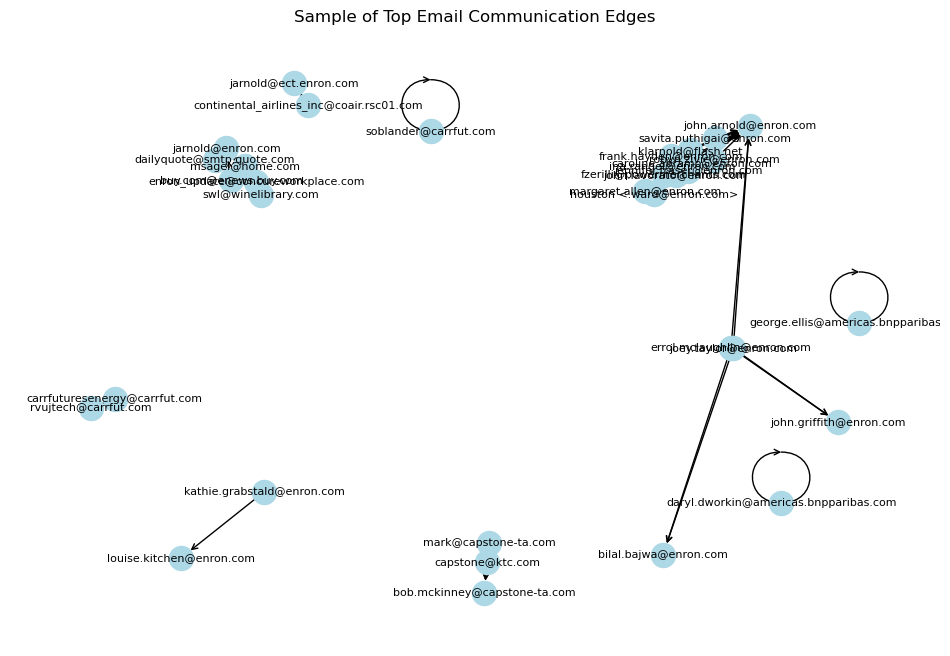

In [42]:
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt

def parse_email_addresses(email_text):
    """
    Extract the 'From' address and a list of 'To' addresses from raw email text.
    """
    from_match = re.search(r"^From:\s*(.*)", email_text, re.MULTILINE)
    to_match   = re.search(r"^To:\s*(.*)", email_text, re.MULTILINE)
    
    sender = from_match.group(1).strip() if from_match else None
    if to_match:
        receivers = [addr.strip() for addr in to_match.group(1).split(',') if addr.strip()]
    else:
        receivers = []
    
    return sender, receivers

# Build communication counts dictionary (limiting to the first N emails for speed)
communication_counts = defaultdict(int)
N = 1000
for email_path in all_email_paths[:N]:
    with open(email_path, 'r', encoding='utf-8', errors='ignore') as f:
        content = f.read()
    sender, receivers = parse_email_addresses(content)
    if sender and receivers:
        for r in receivers:
            communication_counts[(sender, r)] += 1

# Create a directed graph from the communication counts
G = nx.DiGraph()
for (sender, receiver), count in communication_counts.items():
    G.add_edge(sender, receiver, weight=count)

print(f"Number of nodes in the graph: {G.number_of_nodes()}")
print(f"Number of edges in the graph: {G.number_of_edges()}")

# Plot a sample of the communication network (top 30 edges by email count)
sorted_edges = sorted(communication_counts.items(), key=lambda x: x[1], reverse=True)
top_edges = sorted_edges[:30]
subG = nx.DiGraph()
for (s, r), w in top_edges:
    subG.add_edge(s, r, weight=w)

plt.figure(figsize=(12,8))
pos = nx.spring_layout(subG, k=0.3)
nx.draw_networkx_nodes(subG, pos, node_size=300, node_color='lightblue')
nx.draw_networkx_labels(subG, pos, font_size=8)
nx.draw_networkx_edges(subG, pos, arrowstyle='->', arrowsize=10)
plt.title("Sample of Top Email Communication Edges")
plt.axis('off')
plt.show()


# The Solution: implement a data science solution to the problem you are trying to solve.

Briefly describe the idea of your solution to the problem in the following cell:

In [ ]:
Solution Approach:

My solution starts by constructing a communication network from the Enron email dataset. Extract sender and receiver information from each email to form nodes (email addresses) and edges (email communications with associated counts). 
Using network analysis, I calculate key metrics such as in-degree (number of emails received) and out-degree (number of emails sent). 

To detect anomalies that might indicate fraudulent or unusual activity, first identify the most active nodes by ranking them based on these metrics. 
Then, I enhance this initial screening by applying statistical outlier detection—calculating the mean and standard deviation for in-degree and out-degree values and 
flagging any nodes that exceed a defined threshold (e.g., mean + 2×standard deviation). 

This approach allows us to narrow down the list of email addresses to those that display irregular communication patterns. 


Write codes to implement the solution in python:

In [48]:
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary



# Compute in-degree and out-degree centrality (weighted by email counts)
in_degree_centrality = G.in_degree(weight='weight')
out_degree_centrality = G.out_degree(weight='weight')

# Convert to dictionaries for easier processing
in_degree_dict = {node: val for node, val in in_degree_centrality}
out_degree_dict = {node: val for node, val in out_degree_centrality}

# Find top 5 nodes based on in-degree (most emails received) and out-degree (most emails sent)
top_in = sorted(in_degree_dict.items(), key=lambda x: x[1], reverse=True)[:5]
top_out = sorted(out_degree_dict.items(), key=lambda x: x[1], reverse=True)[:5]

print("Top 5 most emailed addresses (in-degree):")
for addr, cnt in top_in:
    print(f"{addr} -> {cnt}")

print("\nTop 5 most active senders (out-degree):")
for addr, cnt in top_out:
    print(f"{addr} -> {cnt}")

# Explanation:
# The addresses with extremely high in-degree or out-degree may be involved in abnormal communication patterns.
# For instance, an account receiving a disproportionately high number of emails might be under targeted communication,
# while an account sending a large volume of emails could be engaging in spam-like behavior.




# Compute Statistical Outlier Thresholds
# calculate the mean and standard deviation for in-degree and out-degree values.
# Then, define a threshold (e.g., mean + 2×std) above which a node is considered anomalous.

import numpy as np

# Convert the centrality measures to numpy arrays
in_values = np.array(list(in_degree_dict.values()))
out_values = np.array(list(out_degree_dict.values()))

# Calculate mean and standard deviation for in-degree and out-degree
in_mean, in_std = in_values.mean(), in_values.std()
out_mean, out_std = out_values.mean(), out_values.std()

# Define thresholds (e.g., mean + 2 * standard deviation)
in_threshold = in_mean + 2 * in_std
out_threshold = out_mean + 2 * out_std

print("In-Degree: Mean =", in_mean, "Std =", in_std, "Threshold =", in_threshold)
print("Out-Degree: Mean =", out_mean, "Std =", out_std, "Threshold =", out_threshold)



# Flag anomalous nodes for in-degree and out-degree
anomalous_in = {node: val for node, val in in_degree_dict.items() if val > in_threshold}
anomalous_out = {node: val for node, val in out_degree_dict.items() if val > out_threshold}

print("\nAnomalous nodes by in-degree (potential high receivers):")
for node, val in anomalous_in.items():
    print(f"{node}: {val}")

print("\nAnomalous nodes by out-degree (potential high senders):")
for node, val in anomalous_out.items():
    print(f"{node}: {val}")



Top 5 most emailed addresses (in-degree):
john.arnold@enron.com -> 410
jarnold@enron.com -> 121
bilal.bajwa@enron.com -> 46
john.griffith@enron.com -> 46
bob.mckinney@capstone-ta.com -> 42

Top 5 most active senders (out-degree):
joey.taylor@enron.com -> 73
errol.mclaughlin@enron.com -> 67
soblander@carrfut.com -> 37
margaret.allen@enron.com -> 34
ina.rangel@enron.com -> 33
In-Degree: Mean = 2.6818181818181817 Std = 20.809714435235126 Threshold = 44.30124705228843
Out-Degree: Mean = 2.6818181818181817 Std = 6.6962429332789 Threshold = 16.074304048375982

Anomalous nodes by in-degree (potential high receivers):
jarnold@enron.com: 121
john.arnold@enron.com: 410
bilal.bajwa@enron.com: 46
john.griffith@enron.com: 46

Anomalous nodes by out-degree (potential high senders):
caroline.abramo@enron.com: 31
jennifer.fraser@enron.com: 25
soblander@carrfut.com: 37
margaret.allen@enron.com: 34
ina.rangel@enron.com: 33
fzerilli@powermerchants.com: 17
errol.mclaughlin@enron.com: 67
dailyquote@smtp.qu

# Results: summarize and visualize the results discovered from the analysis

Please use figures or tables to present the results.


Top 10 most frequent communication pairs:


,Sender,Receiver,Email_Count
16,soblander@carrfut.com,soblander@carrfut.com,37
105,margaret.allen@enron.com,john.arnold@enron.com,27
115,joey.taylor@enron.com,john.arnold@enron.com,25
112,capstone@ktc.com,bob.mckinney@capstone-ta.com,24
117,joey.taylor@enron.com,john.griffith@enron.com,24
116,joey.taylor@enron.com,bilal.bajwa@enron.com,24
14,caroline.abramo@enron.com,john.arnold@enron.com,24
96,errol.mclaughlin@enron.com,john.arnold@enron.com,23
97,errol.mclaughlin@enron.com,bilal.bajwa@enron.com,22
98,errol.mclaughlin@enron.com,john.griffith@enron.com,22


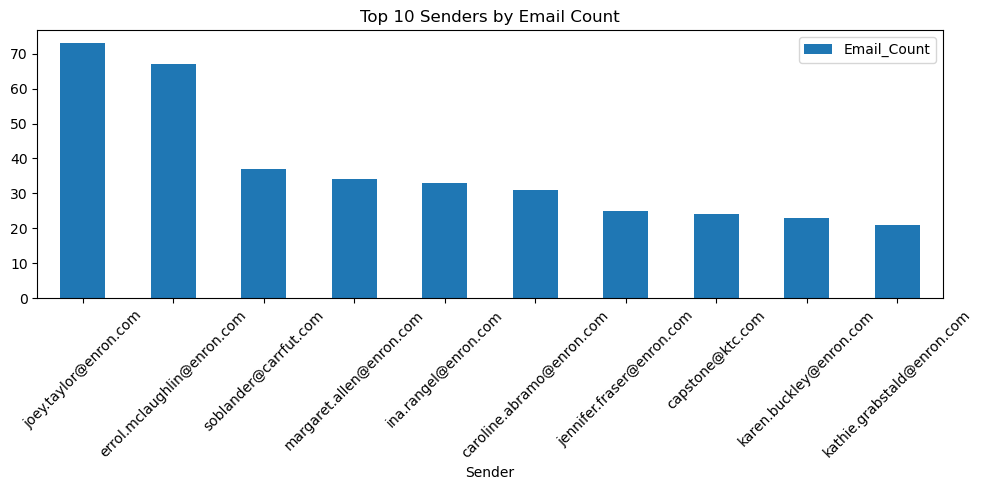

In [50]:
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary

import pandas as pd

# Convert the communication_counts dictionary to a DataFrame for analysis
edges_df = pd.DataFrame([
    (s, r, w) for ((s, r), w) in communication_counts.items()
], columns=["Sender", "Receiver", "Email_Count"])

# Sort by Email_Count in descending order
edges_df = edges_df.sort_values(by="Email_Count", ascending=False)

print("Top 10 most frequent communication pairs:")
display(edges_df.head(10))

# Visualize the top 10 senders by total out-degree (i.e., total emails sent)
senders_df = edges_df.groupby("Sender")["Email_Count"].sum().reset_index()
senders_df = senders_df.sort_values("Email_Count", ascending=False)
top_senders = senders_df.head(10)

top_senders.plot(
    kind="bar",
    x="Sender",
    y="Email_Count",
    figsize=(10,5),
    title="Top 10 Senders by Email Count"
)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
"""
summarize the results discovered from the analysis:

The analysis of the Enron email dataset revealed that a small number of nodes dominate the communication network. Key findings include:

- Communication Patterns:
  The top communication pairs indicate that certain sender-receiver relationships occur very frequently. A few email addresses (such as `john.arnold@enron.com` and `jarnold@enron.com`) receive significantly more emails than the average node, while others (such as `joey.taylor@enron.com`) are among the most active senders.

- Anomaly Detection via Centrality Metrics: 
  By computing the in-degree and out-degree of nodes, we identified several accounts that exceed the statistical thresholds (mean + 2×standard deviation). 
  These accounts are flagged as anomalous. Although high activity alone does not prove fraudulent behavior, it highlights nodes that merit further investigation.

- Implications for Fraud Detection: 
  The anomalous nodes could be indicative of targeted or suspicious communication patterns. 
  For example, accounts with unusually high in-degree may be central points in information dissemination or be under heavy targeted communication, 
  while those with high out-degree might be responsible for distributing large volumes of information. 
  These findings serve as a basis for further temporal analysis and content analysis to determine if these patterns correlate with fraudulent activity.

Overall, the approach effectively reduces the vast dataset to a focused subset of nodes for deeper scrutiny, aligning with my goal of detecting potential anomalies in the communication network.

"""
